In [ ]:
!pip install mlxtend

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import os

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import preprocessing

In [2]:
def get_content_binary_word(path):    
    # get full character content of a word num i 
    x_word = []
    
    with open(path, "r") as f:            
        for line_idx, line in enumerate(f):
            # each line is a character
            x_char_str = line.strip().split(' ')
            x_char = [int(pixel_i) for pixel_i in x_char_str]
            x_word.append(x_char)
    return np.array(x_word)
# test case
word = get_content_binary_word('./data/train_words/text_1.txt')
print (word)
print (word.shape)

def convert_word2label(word):
    alphabet = "abcdefghijklmnopqrstuvwxyz"
    
    le = preprocessing.LabelEncoder()
    le.fit(list(alphabet))
    return le.transform(word)
    
def get_dataset(data_dir, mode="train"):
    words_file_dir = os.path.join(data_dir, '{}_words'.format(mode))
    words_list_path = os.path.join(data_dir, '{}_words.txt'.format(mode))

    X = []
    y = []    
    with open(words_list_path) as f:
        for line in f:
            line = line.strip()
            idx, word = line.split()
            
            binary_word_path = os.path.join(words_file_dir, 'text_{}.txt'.format(idx))
            X.append(get_content_binary_word(binary_word_path))
            y.append(convert_word2label(list(word)))
            
    return np.array(X), np.array(y)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 1 ... 1 1 0]
 [1 0 0 ... 0 0 0]]
(11, 128)


In [3]:
data_dir = './data'

X_train, y_train = get_dataset(data_dir, mode="train")
X_train, X_cross, y_train, y_cross = train_test_split(X_train, y_train,
                                                    test_size=0.33, random_state=42)
X_test, y_test = get_dataset(data_dir, mode="test")

In [4]:
print (X_train.shape, y_train.shape)
print (X_train[0].shape, y_train[0].shape)
print (X_train[0][0])

(9032,) (9032,)
(10, 128) (10,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0
 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [5]:
X_train = np.vstack(X_train)
y_train = np.hstack(y_train)
X_cross = np.vstack(X_cross)
y_cross = np.hstack(y_cross)
X_test = np.vstack(X_test)
y_test = np.hstack(y_test)

In [6]:
list_alpha = np.array([0.1, 1])
score_train = np.zeros(len(list_alpha))
score_cross = np.zeros(len(list_alpha))
count = 0

for alpha in list_alpha:
    bayes = LinearSVC(dual=False, C=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_cross[count]= bayes.score(X_cross, y_cross)
    count += 1

In [7]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_cross])
models = pd.DataFrame(data = matrix, columns = 
             ['Alpha', 'Train Accuracy', 'Cross Accuracy'])
models.head(n=10)

,Alpha,Train Accuracy,Cross Accuracy
0,0.1,0.775337,0.767235
1,1.0,0.776773,0.768354


In [8]:
best_index_model = models['Cross Accuracy'].idxmax()
model_describe = models.iloc[best_index_model][:]
model_describe

Alpha             1.000000
Train Accuracy    0.776773
Cross Accuracy    0.768354
Name: 1, dtype: float64

In [9]:
models.iloc[best_index_model][:]

Alpha             1.000000
Train Accuracy    0.776773
Cross Accuracy    0.768354
Name: 1, dtype: float64

In [10]:
# Train linear SVM
svm = LinearSVC(dual=False,
                C=models.iloc[best_index_model]['Alpha'])
# flatten input
svm.fit(np.vstack(X_train), np.hstack(y_train))

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [11]:
print("Test score with linear SVM: %f" % svm.score(X_test, y_test))

Test score with linear SVM: 0.772417


In [12]:
print (X_train.shape)
print (y_train.shape)

(67550, 128)
(67550,)


In [13]:
# Save model 
from sklearn.externals import joblib
joblib.dump(svm, 'Sklearn_SVM.sav')

/home/mufc1997/anaconda3/envs/bayesian/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['Sklearn_SVM.sav']

In [14]:
from sklearn.externals import joblib
model = joblib.load('Sklearn_SVM.sav')

In [16]:
print("Test score with linear SVM: %f" % model.score(X_test, y_test))

Test score with linear SVM: 0.772417


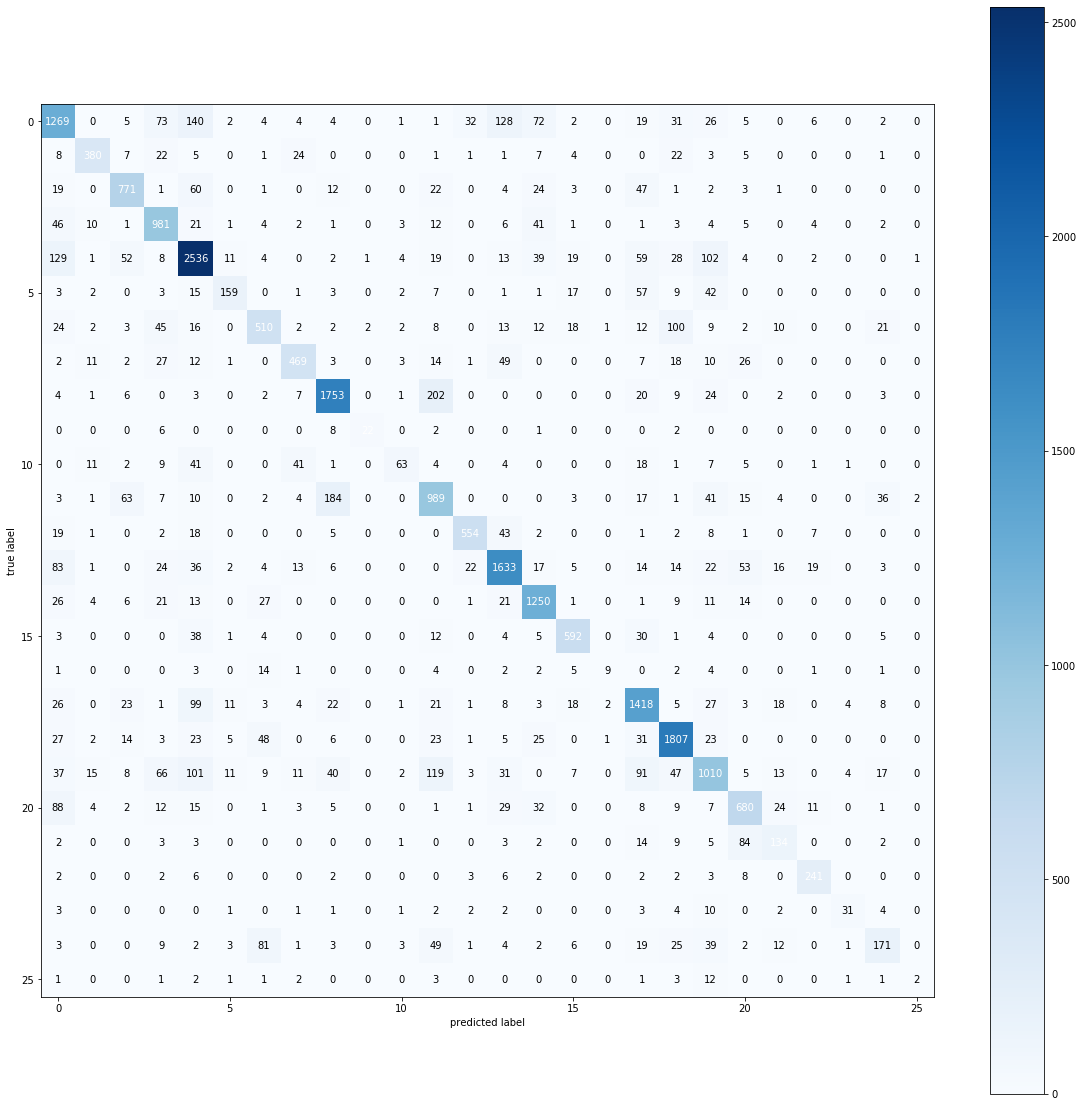

In [34]:
confusion_matrix = metrics.confusion_matrix(y_test, model.predict(X_test))
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix,
                                colorbar=True,
                                figsize=(20, 20))
plt.show()

In [25]:
print(metrics.classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69      1826
           1       0.85      0.77      0.81       492
           2       0.80      0.79      0.80       971
           3       0.74      0.85      0.79      1149
           4       0.79      0.84      0.81      3034
           5       0.76      0.49      0.60       322
           6       0.71      0.63      0.66       814
           7       0.79      0.72      0.75       655
           8       0.85      0.86      0.86      2037
           9       0.88      0.54      0.67        41
          10       0.72      0.30      0.43       209
          11       0.65      0.72      0.68      1382
          12       0.89      0.84      0.86       663
          13       0.81      0.82      0.82      1987
          14       0.81      0.89      0.85      1405
          15       0.84      0.85      0.85       699
          16       0.69      0.18      0.29        49
          17       0.75    